In [72]:
#|default_exp models

In [73]:
#| export
import sys
sys.path.append('/opt/slh/archive/software/graphnet/src')
sys.path.append('/opt/slh/icecube/')
import torch
from x_transformers import ContinuousTransformerWrapper, Encoder, Decoder
from torch import nn, einsum
from einops import rearrange
import torch.nn.functional as F
from datasets import load_from_disk
from abc import abstractmethod
from torch import Tensor
from typing import Optional, Any
import scipy
import numpy as np
from graphnet.models.task.reconstruction import DirectionReconstructionWithKappa, AzimuthReconstructionWithKappa, ZenithReconstruction
from graphnet.training.loss_functions import VonMisesFisher3DLoss,  VonMisesFisher2DLoss, EuclideanDistanceLoss
from graphnet.training.labels import Direction


In [74]:


# | export

class EuclideanDistanceLossG(torch.nn.Module):
    def __init__(self, eps=1e-6, reduction='mean'):
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        
    def forward(self, prediction, target):
        diff = prediction - target
        loss = torch.norm(diff, dim=1) + self.eps
        if self.reduction == 'mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        return loss
    
    
class VonMisesFisher3DLossCosineSimularityLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.vonmis = VonMisesFisher3DLoss()
        self.cosine = nn.CosineSimilarity(dim=1, eps=eps)
        
    def forward(self, y_pred, y_true):
        return (self.vonmis(y_pred, y_true) + (1-self.cosine(y_pred[:, :3], y_true).mean()))/2
    
    
class VonMisesFisher3DLossEcludeLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.vonmis = VonMisesFisher3DLoss()
        self.cosine = EuclideanDistanceLossG()
        
    def forward(self, y_pred, y_true):
        return (self.vonmis(y_pred, y_true) + self.cosine(y_pred[:, :3], y_true))/2
    
class VonMisesFisher3DLossEcludeLossCosine(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.vonmis = VonMisesFisher3DLoss()
        self.cosine =  nn.CosineSimilarity(dim=1, eps=eps)
        self.euclud = EuclideanDistanceLossG()
        self.eps = eps
        
    def forward(self, y_pred, y_true):
        return (self.vonmis(y_pred, y_true) + 
                (self.euclud(y_pred[:, :3], y_true)) +
                (1-self.cosine(y_pred[:, :3], y_true).mean()))/3
    


class VonMisesFisher2DLossL1Loss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.vonmis = VonMisesFisher2DLoss()
        self.l1 = nn.L1Loss()
        
    def forward(self, y_pred, y_true):
        vm = self.vonmis(y_pred[:, :2], y_true)
        l1 = self.l1(y_pred[:, 2], y_true[:, -1])
        return (vm + l1)/2
        
    
    
class LogCoshLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(torch.log(torch.cosh(ey_t + 1e-12)))


class SigmoidRange(nn.Module):
    def __init__(self, low, high):
        super().__init__()
        self.low = low
        self.high = high

    def forward(self, x):
        return torch.sigmoid(x) * (self.high - self.low) + self.low


class Adjustoutput(nn.Module):
    def __init__(self):
        super().__init__()
        self.az = SigmoidRange(6.436839548775502e-08, 6.2891)
        self.zn = SigmoidRange(8.631674577710722e-05, 3.1417)

    def forward(self, x):
        x[:, 0] = self.az(x[:, 0])
        x[:, 1] = self.zn(x[:, 1])
        return x


class PoolingWithMask(nn.Module):
    def __init__(self, pool_type):
        super().__init__()
        self.pool_type = pool_type

    def forward(self, x, mask):
        # Multiply the mask with the input tensor to zero out the padded values
        x = x * mask.unsqueeze(-1)

        if self.pool_type == "mean":
            # Sum the values along the sequence dimension
            x = torch.sum(x, dim=1)

            # Divide the sum by the number of non-padded values (i.e. the sum of the mask)
            x = x / torch.sum(mask, dim=1, keepdim=True)
        elif self.pool_type == "max":
            # Find the maximum value along the sequence dimension
            x, _ = torch.max(x, dim=1)
        elif self.pool_type == "min":
            # Find the minimum value along the sequence dimension
            x, _ = torch.min(x, dim=1)
        else:
            raise ValueError("Invalid pool_type. Choose from ['mean', 'max', 'min']")

        return x


class MeanPoolingWithMask(nn.Module):
    def __init__(self):
        super(MeanPoolingWithMask, self).__init__()

    def forward(self, x, mask):
        # Multiply the mask with the input tensor to zero out the padded values
        x = x * mask.unsqueeze(-1)

        # Sum the values along the sequence dimension
        x = torch.sum(x, dim=1)

        # Divide the sum by the number of non-padded values (i.e. the sum of the mask)
        x = x / torch.sum(mask, dim=1, keepdim=True)

        return x


class FeedForward(nn.Module):
    def __init__(self, dim, dim_out=None, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult), nn.GELU(), nn.Linear(dim * mult, dim_out)
        )

    def forward(self, x):
        return self.net(x)


class IceCubeModelEncoderV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=6,
            dim_out=128,
            max_seq_len=150,
            attn_layers=Encoder(dim=128, depth=6, heads=8),
        )

        # self.pool = MeanPoolingWithMask()
        self.head = FeedForward(128, 2)

    def forward(self, batch):
        x, mask = batch["event"], batch["mask"]
        x = self.encoder(x, mask=mask)
        x = x.mean(dim=1)
        x = self.head(x)
        return x


class IceCubeModelEncoderV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=8,
            dim_out=128,
            max_seq_len=150,
            attn_layers=Encoder(dim=128, depth=6, heads=8),
        )

        self.pool = MeanPoolingWithMask()
        self.head = FeedForward(128, 2)

    def forward(self, batch):
        x, mask = batch["event"], batch["mask"]
        x = self.encoder(x, mask=mask)
        x = self.pool(x, mask)
        x = self.head(x)
        return x


class IceCubeModelEncoderV1CombinePool(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=8,
            dim_out=128,
            max_seq_len=150,
            attn_layers=Encoder(dim=128, depth=6, heads=8),
        )

        self.pool_mean = PoolingWithMask('mean')
        self.pool_max = PoolingWithMask('max')
        self.head = FeedForward(128 * 2, 2)

    def forward(self, batch):
        x, mask = batch["event"], batch["mask"]
        x = self.encoder(x, mask=mask)
        x = torch.concat([self.pool_mean(x, mask), self.pool_max(x, mask)], dim=1)
        x = self.head(x)
        return x


class always:
    def __init__(self, val):
        self.val = val

    def __call__(self, *args, **kwargs):
        return self.val


def l2norm(t, groups=1):
    t = rearrange(t, "... (g d) -> ... g d", g=groups)
    t = F.normalize(t, p=2, dim=-1)
    return rearrange(t, "... g d -> ... (g d)")


class TokenEmbedding(nn.Module):
    def __init__(self, dim, num_tokens, l2norm_embed=False):
        super().__init__()
        self.l2norm_embed = l2norm_embed
        self.emb = nn.Embedding(num_tokens, dim, padding_idx=0)

    def forward(self, x):
        token_emb = self.emb(x)
        return l2norm(token_emb) if self.l2norm_embed else token_emb

    def init_(self):
        nn.init.kaiming_normal_(self.emb.weight)


class IceCubeModelEncoderSensorEmbeddinng(nn.Module):
    def __init__(self, dim=128, in_features=14):
        super().__init__()
        self.token_emb = TokenEmbedding(dim, num_tokens=5161)
        self.post_norma = nn.LayerNorm(dim)
        self.token_emb.init_()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=in_features + dim,
            dim_out=256,
            max_seq_len=150,
            attn_layers=Encoder(dim=256, depth=6, heads=8),
        )

        self.pool = MeanPoolingWithMask()
        self.head = FeedForward(256, 2)

    def forward(self, batch):
        x, mask, sensor_id = batch["event"], batch["mask"], batch["sensor_id"]
        embed = self.token_emb(sensor_id)
        embed = self.post_norma(embed)
        x = torch.cat([x, embed], dim=-1)
        x = self.encoder(x, mask=mask)
        x = self.pool(x, mask)
        x = self.head(x)
        return x


class IceCubeModelEncoderSensorEmbeddinngV1(nn.Module):
    def __init__(self, dim=128, in_features=6):
        super().__init__()
        self.token_emb = TokenEmbedding(dim, num_tokens=5161)
        self.post_norma = nn.LayerNorm(dim)
        self.token_emb.init_()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=in_features + dim,
            dim_out=256,
            max_seq_len=150,
            attn_layers=Encoder(dim=256, depth=6, heads=8),
        )

        self.pool = MeanPoolingWithMask()
        self.head = FeedForward(256, 2)

    def forward(self, batch):
        x, mask, sensor_id = batch["event"], batch["mask"], batch["sensor_id"]
        embed = self.token_emb(sensor_id)
        embed = self.post_norma(embed)
        x = torch.cat([x, embed], dim=-1)
        x = self.encoder(x, mask=mask)
        x = self.pool(x, mask)
        x = self.head(x)
        return x


class TokenEmbeddingV2(nn.Module):
    def __init__(self, dim, num_tokens, l2norm_embed=False):
        super().__init__()
        self.l2norm_embed = l2norm_embed
        self.emb = nn.Embedding(num_tokens, dim)

    def forward(self, x):
        token_emb = self.emb(x)
        return l2norm(token_emb) if self.l2norm_embed else token_emb

    def init_(self):
        nn.init.kaiming_normal_(self.emb.weight)


class IceCubeModelEncoderSensorEmbeddinngV2(nn.Module):
    def __init__(self, dim=128, in_features=6):
        super().__init__()
        self.token_emb = TokenEmbeddingV2(dim, num_tokens=5161)
        self.post_norma = nn.LayerNorm(dim)
        self.token_emb.init_()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=in_features + dim,
            dim_out=256,
            max_seq_len=196,
            attn_layers=Encoder(dim=256, depth=6, heads=8),
        )

        self.pool = MeanPoolingWithMask()
        self.head = FeedForward(256, 2)

    def forward(self, batch):
        x, mask, sensor_id = batch["event"], batch["mask"], batch["sensor_id"]
        embed = self.token_emb(sensor_id)
        x = torch.cat([x, embed], dim=-1)
        x = self.encoder(x, mask=mask)
        x = self.pool(x, mask)
        x = self.head(x)
        return x


class IceCubeModelEncoderSensorEmbeddinngV3(nn.Module):
    def __init__(self, dim=128, in_features=6):
        super().__init__()
        self.token_emb = TokenEmbeddingV2(dim, num_tokens=5161)
        self.post_norma = nn.LayerNorm(dim)
        self.token_emb.init_()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=in_features + dim,
            dim_out=256,
            max_seq_len=150,
            attn_layers=Encoder(dim=256, depth=6, heads=8),
        )

        self.pool = MeanPoolingWithMask()
        self.head = FeedForward(256, 2)
        self.sigmout = Adjustoutput()

    def forward(self, batch):
        x, mask, sensor_id = batch["event"], batch["mask"], batch["sensor_id"]
        embed = self.token_emb(sensor_id)
        x = torch.cat([x, embed], dim=-1)
        x = self.encoder(x, mask=mask)
        x = self.pool(x, mask)
        x = self.head(x)
        s = self.sigmout(x)
        return x
    
class IceCubeModelEncoderSensorEmbeddinngV4(nn.Module):
    def __init__(self, dim=128, in_features=9):
        super().__init__()
        self.token_emb = TokenEmbeddingV2(dim, num_tokens=5168)
        self.post_norma = nn.LayerNorm(dim)
        self.token_emb.init_()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=in_features + dim,
            dim_out=256,
            max_seq_len=480,
            post_emb_norm = True,
            attn_layers=Encoder(dim=256, 
                                depth=8, 
                                heads=8, 
                                ff_glu = True,
                                rotary_pos_emb = True),
        )

        self.pool_mean = PoolingWithMask("mean")
        self.pool_max = PoolingWithMask("max")
        
        self.out = DirectionReconstructionWithKappa(
            hidden_size=256 * 2,
            target_labels='direction',
            loss_function=VonMisesFisher3DLoss(),
        )
        
        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, batch):
        x, mask, sensor_id = batch["event"], batch["mask"], batch["sensor_id"]
        embed = self.token_emb(sensor_id)
        x = torch.cat([x, embed], dim=-1)
        x = self.encoder(x, mask=mask)
        x = torch.concat([self.pool_mean(x, mask), self.pool_max(x, mask)], dim=1)
        x = self.out(x)
        return x
    
    



In [75]:
model = IceCubeModelEncoderSensorEmbeddinngV4().eval()
event = torch.rand(4, 100, 9)
mask = torch.ones(4, 100, dtype=torch.bool)
sensor_id = torch.randint(0, 5161, (4, 100))
input = dict(event=event, mask=mask, sensor_id=sensor_id)
with torch.no_grad():
    y = model(input)

y.shape

torch.Size([4, 4])

In [76]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [77]:
count_parameters(model)/1000000

11.277827

In [78]:
# | export


class IceCubeModelEncoderV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=8,
            dim_out=128,
            max_seq_len=150,
            attn_layers=Encoder(dim=128, depth=6, heads=8),
        )

        self.pool = MeanPoolingWithMask()
        self.out = DirectionReconstructionWithKappa(128)

    def forward(self, batch):
        x, mask = batch["event"], batch["mask"]
        x = self.encoder(x, mask=mask)
        x = self.pool(x, mask)
        return self.out(x)


class EncoderWithDirectionReconstruction(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=8,
            dim_out=128,
            max_seq_len=150,
            attn_layers=Encoder(dim=128, depth=6, heads=8),
        )

        self.pool_mean = PoolingWithMask("mean")
        self.pool_max = PoolingWithMask("max")
        self.out = DirectionReconstructionWithKappa(
            hidden_size=256,
            target_labels='direction',
            loss_function=VonMisesFisher3DLoss(),
        )

    def forward(self, batch):
        x, mask = batch["event"], batch["mask"]
        x = self.encoder(x, mask=mask)
        x = torch.concat([self.pool_mean(x, mask), self.pool_max(x, mask)], dim=1)
        return self.out(x)


class EncoderWithDirectionReconstructionV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=9,
            dim_out=128,
            max_seq_len=150,
            attn_layers=Encoder(dim=128, depth=6, heads=8),
        )

        self.pool_mean = PoolingWithMask("mean")
        self.pool_max = PoolingWithMask("max")
        self.pool_min = PoolingWithMask("min")
        self.ae = FeedForward(384, 384)
        self.out = DirectionReconstructionWithKappa(
            hidden_size=384,
            target_labels='direction',
            loss_function=VonMisesFisher3DLoss(),
        )

    def forward(self, batch):
        x, mask = batch["event"], batch["mask"]
        x = self.encoder(x, mask=mask)
        x = torch.concat([self.pool_mean(x, mask), 
                          self.pool_max(x, mask), 
                          self.pool_min(x, mask)], dim=1)
        x = self.ae(x)
        return self.out(x)
    
class EncoderWithDirectionReconstructionV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=9,
            dim_out=128,
            max_seq_len=150,
            attn_layers=Encoder(dim=128, depth=6, heads=8),
        )

        self.pool_mean = PoolingWithMask("mean")
        self.pool_max = PoolingWithMask("max")
        self.out = DirectionReconstructionWithKappa(
            hidden_size=256,
            target_labels='direction',
            loss_function=VonMisesFisher3DLoss(),
        )

    def forward(self, batch):
        x, mask = batch["event"], batch["mask"]
        x = self.encoder(x, mask=mask)
        x = torch.concat([self.pool_mean(x, mask), self.pool_max(x, mask)], dim=1)
        return self.out(x)
    
class EncoderWithDirectionReconstructionV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=8,
            dim_out=128,
            max_seq_len=150,
            attn_layers=Encoder(dim=128, depth=6, heads=8),
        )

        self.pool_mean = PoolingWithMask("mean")
        self.pool_max = PoolingWithMask("max")

        self.azimuth_task = AzimuthReconstructionWithKappa(
            hidden_size=256,
            loss_function=VonMisesFisher2DLoss(),
            target_labels=["azimuth", "kappa"],
        )

        self.zenith_task = ZenithReconstruction(
            hidden_size=256,
            loss_function=nn.L1Loss(),
            target_labels=["zenith"],
        )

    def forward(self, batch):
        x, mask = batch["event"], batch["mask"]
        x = self.encoder(x, mask=mask)
        x = torch.concat([self.pool_mean(x, mask), self.pool_max(x, mask)], dim=1)
        az = self.azimuth_task(x)
        zn = self.zenith_task(x)
        return torch.concat([az, zn], dim=1)


class EncoderWithDirectionReconstructionV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=8,
            dim_out=128,
            max_seq_len=150,
            attn_layers=Encoder(dim=128, depth=6, heads=8),
        )

        self.pool_mean = PoolingWithMask("mean")
        self.pool_max = PoolingWithMask("max")

        self.azimuth_task = AzimuthReconstructionWithKappa(
            hidden_size=256,
            loss_function=VonMisesFisher2DLoss(),
            target_labels=["azimuth", "kappa"],
        )

        self.zenith_task = ZenithReconstruction(
            hidden_size=256,
            loss_function=nn.L1Loss(),
            target_labels=["zenith"],
        )

    def forward(self, batch):
        x, mask = batch["event"], batch["mask"]
        x = self.encoder(x, mask=mask)
        x = torch.concat([self.pool_mean(x, mask), self.pool_max(x, mask)], dim=1)
        az = self.azimuth_task(x)
        zn = self.zenith_task(x)
        return torch.concat([az, zn], dim=1)


class EncoderWithDirectionReconstructionV4(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=9,
            dim_out=128,
            max_seq_len=150,
            post_emb_norm = True,
            attn_layers=Encoder(dim=128,
                                depth=8,
                                heads=8,
                                ff_glu = True,
                                rotary_pos_emb = True),
        )

        self.pool_mean = PoolingWithMask("mean")
        self.pool_max = PoolingWithMask("max")
        self.out = DirectionReconstructionWithKappa(
            hidden_size=256,
            target_labels='direction',
            loss_function=VonMisesFisher3DLoss(),
        )
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
    def forward(self, batch):
        x, mask = batch["event"], batch["mask"]
        x = self.encoder(x, mask=mask)
        x = torch.concat([self.pool_mean(x, mask), self.pool_max(x, mask)], dim=1)
        return self.out(x)
    

class EncoderWithDirectionReconstructionV5(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=9,
            dim_out=128,
            max_seq_len=150,
            post_emb_norm = True,
            attn_layers=Encoder(dim=128,
                                depth=8,
                                heads=8,
                                ff_glu = True,
                                rotary_pos_emb = True),
        )

        self.cls_token = nn.Parameter(torch.rand(1, 1, 128))
        self.out = DirectionReconstructionWithKappa(
            hidden_size=128,
            target_labels='direction',
            loss_function=VonMisesFisher3DLoss(),
        )
        
        self.apply(self._init_weights)
        torch.nn.init.trunc_normal_(self.cls_token, std=0.02)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
    def forward(self, batch):
        x, mask = batch["event"], batch["mask"]
        bs = x.shape[0]
        cls_tokens  = self.cls_token.expand(bs, -1, -1)
        mask = torch.cat([torch.ones(bs, 1, dtype=torch.bool, device=x.device), mask], dim=1)
        x = self.encoder(x, mask=mask, prepend_embeds=cls_tokens)
        #pool on cls token
        x = x[:, 0]
        return self.out(x)
    
    
import math
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim=16, M=10000):
        super().__init__()
        self.dim = dim
        self.M = M

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.M) / half_dim
        emb = torch.exp(torch.arange(half_dim, device=device) * (-emb))
        emb = x[...,None] * emb[None,...]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    
    
class ExtractorV0(nn.Module):
    def __init__(self, dim_base=128, dim=384, proj = True):
        super().__init__()
        self.emb = SinusoidalPosEmb(dim=dim_base)
        self.emb2 = SinusoidalPosEmb(dim=dim_base//2)
        self.aux_emb = nn.Embedding(2,dim_base//2)
        self.qe_emb = nn.Embedding(2,dim_base//2)
        self.proj = nn.Linear(dim_base*7,dim) if proj else nn.Identity()
        
    def forward(self, x, Lmax=None):
        pos = x['pos'] if Lmax is None else x['pos'][:,:Lmax]
        charge = x['charge'] if Lmax is None else x['charge'][:,:Lmax]
        time = x['time'] if Lmax is None else x['time'][:,:Lmax]
        auxiliary = x['aux'] if Lmax is None else x['auxiliary'][:,:Lmax]
        qe = x['qe'] if Lmax is None else x['qe'][:,:Lmax]
        ice_properties = x['ice_properties'] if Lmax is None else x['ice_properties'][:,:Lmax]
        
        x = torch.cat([self.emb(100*pos).flatten(-2), self.emb(40*charge),
                       self.emb(100*time),self.aux_emb(auxiliary),self.qe_emb(qe),
                       self.emb2(50*ice_properties).flatten(-2)],-1)
        x = self.proj(x)
        return x

    
    
class ExtractorV1(nn.Module):
    def __init__(self, dim_base=128):
        super().__init__()
        self.emb = SinusoidalPosEmb(dim=dim_base)
        self.emb2 = SinusoidalPosEmb(dim=dim_base//2)
        self.aux_emb = TokenEmbeddingV2(dim_base//4, 2, True)
        self.qe_emb = TokenEmbeddingV2(dim_base//4, 2, True)
        self.rank = TokenEmbeddingV2(dim_base//4, 4, True)
        
    def forward(self, x):
        ice_properties = torch.stack([x['scattering'], x['absorption']], dim=2)
        
        x = torch.cat([self.emb(100*x['pos']).flatten(-2), 
                       self.emb(40*x['charge']),
                       self.emb(100*x['time']),
                       self.aux_emb(x["aux"]),
                       self.qe_emb(x["qe"]),
                       self.rank(x["rank"]),
                       self.emb2(50*ice_properties).flatten(-2)],-1)
        return x
    

class ExtractorV2(nn.Module):
    def __init__(self, dim_base=128, out_dim=196):
        super().__init__()
        self.emb = SinusoidalPosEmb(dim=dim_base)
        self.emb2 = SinusoidalPosEmb(dim=dim_base//2)
        self.aux_emb = TokenEmbeddingV2(dim_base//4, 2, True)
        self.qe_emb = TokenEmbeddingV2(dim_base//4, 2, True)
        self.rank = TokenEmbeddingV2(dim_base//4, 4, True)
        self.out = nn.Linear(864, out_dim)
        
    def forward(self, x):
        ice_properties = torch.stack([x['scattering'], x['absorption']], dim=2)
        
        x = torch.cat([self.emb(100*x['pos']).flatten(-2), 
                       self.emb(40*x['charge']),
                       self.emb(100*x['time']),
                       self.aux_emb(x["aux"]),
                       self.qe_emb(x["qe"]),
                       self.rank(x["rank"]),
                       self.emb2(50*ice_properties).flatten(-2)],-1)
        return x
    
    
class ExtractorV2(nn.Module):
    def __init__(self, dim_base=128, out_dim=196):
        super().__init__()
        self.emb = SinusoidalPosEmb(dim=dim_base)
        self.emb2 = SinusoidalPosEmb(dim=dim_base//2)
        self.aux_emb = TokenEmbeddingV2(dim_base//4, 2, True)
        self.qe_emb = TokenEmbeddingV2(dim_base//4, 2, True)
        self.rank = TokenEmbeddingV2(dim_base//4, 4, True)
        self.out = nn.Linear(864, out_dim)
        
    def forward(self, x):
        ice_properties = torch.stack([x['scattering'], x['absorption']], dim=2)
        
        x = torch.cat([self.emb(100*x['pos']).flatten(-2), 
                       self.emb(40*x['charge']),
                       self.emb(100*x['time']),
                       self.aux_emb(x["aux"]),
                       self.qe_emb(x["qe"]),
                       self.rank(x["rank"]),
                       self.emb2(50*ice_properties).flatten(-2)],-1)
        return x
    
    
class EncoderWithDirectionReconstructionV6(nn.Module):
    def __init__(self, dim_in = 864, dim_out=256, attn_depth = 8, heads = 8):
        super().__init__()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=dim_in,
            dim_out=dim_out,
            max_seq_len=440,
            post_emb_norm = True,
            attn_layers=Encoder(dim=dim_out,
                                depth=attn_depth,
                                heads=heads,
                                ff_glu = True,
                                rotary_pos_emb = True),
        )

        self.cls_token = nn.Parameter(torch.rand(1, 1, dim_in))
        self.out = DirectionReconstructionWithKappa(
            hidden_size=dim_out,
            target_labels='direction',
            loss_function=VonMisesFisher3DLoss(),
        )
        self.fe = ExtractorV1()
        
        self.apply(self._init_weights)
        torch.nn.init.trunc_normal_(self.cls_token, std=0.02)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
    def forward(self, batch):
        mask = batch["mask"]
        x = self.fe(batch)
        bs = x.shape[0]
        cls_tokens  = self.cls_token.expand(bs, -1, -1)
        x = torch.cat((cls_tokens, x), dim = -2)
        mask = torch.cat([torch.ones(bs, 1, dtype=torch.bool, device=x.device), mask], dim=1)
        x = self.encoder(x, mask=mask)
        x = x[:, 0]
        return self.out(x)
    
    
class EncoderWithDirectionReconstructionV7(nn.Module):
    def __init__(self, dim_in = 864, dim_out=256, attn_depth = 12, heads = 12):
        super().__init__()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=dim_in,
            dim_out=dim_out,
            max_seq_len=440,
            post_emb_norm = True,
            use_abs_pos_emb = False, 
            emb_dropout = 0.1, 
            attn_layers=Encoder(dim=dim_out,
                                depth=attn_depth,
                                heads=heads,
                                ff_glu = True,
                                rotary_pos_emb = True, 
                                use_rmsnorm = True,
                                layer_dropout = 0.1, 
                                attn_dropout = 0.1,    
                                ff_dropout = 0.1)   
        )

        self.pool_mean = PoolingWithMask("mean")
        self.pool_max = PoolingWithMask("max")
        self.cls_token = nn.Parameter(torch.rand(1, 1, dim_in))
        self.out = DirectionReconstructionWithKappa(
            hidden_size=dim_out * 3,
            target_labels='direction',
            loss_function=VonMisesFisher3DLoss(),
        )
        self.fe = ExtractorV1()
        
        self.apply(self._init_weights)
        torch.nn.init.trunc_normal_(self.cls_token, std=0.02)


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
    def forward(self, batch):
        mask = batch["mask"]
        x = self.fe(batch)
        bs = x.shape[0]
        cls_tokens  = self.cls_token.expand(bs, -1, -1)
        x = torch.cat((cls_tokens, x), dim = -2)
        mask = torch.cat([torch.ones(bs, 1, dtype=torch.bool, device=x.device), mask], dim=1)
        x = self.encoder(x, mask=mask)
        x = torch.concat([self.pool_mean(x, mask), self.pool_max(x, mask), x[:, 0]], dim=1)
        return self.out(x)
    
from timm.models.layers import drop_path, to_2tuple, trunc_normal_
class EncoderWithDirectionReconstructionV8(nn.Module):
    def __init__(self, dim_in = 864, dim_out=256, attn_depth = 8, heads = 12):
        super().__init__()
        self.encoder = ContinuousTransformerWrapper(
            dim_in=dim_out,
            dim_out=dim_out,
            max_seq_len=300,
            post_emb_norm = True,
            use_abs_pos_emb = False, 
            emb_dropout = 0.1, 
            attn_layers=Encoder(dim=dim_out,
                                depth=attn_depth,
                                heads=heads,
                                ff_glu = True,
                                rel_pos_bias = True, 
                                layer_dropout = 0.01, 
                                attn_dropout = 0.01,    
                                ff_dropout = 0.01)   
        )
        
        self.cls_token = nn.Linear(dim_out,1,bias=False)
        self.pool_mean = PoolingWithMask("mean")
        self.pool_max = PoolingWithMask("max")
        
        self.out = nn.Linear(dim_out * 3, 3)
        self.fe = ExtractorV0(dim=dim_out, dim_base=96)
        
        self.apply(self._init_weights)
        trunc_normal_(self.cls_token.weight, std=.02)
        #torch.nn.init.trunc_normal_(self.cls_token, std=0.02)


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
    def forward(self, batch):
        mask = batch["mask"]
        x = self.fe(batch, mask.sum(-1).max())
        bs = x.shape[0]
        cls_token = self.cls_token.weight.unsqueeze(0).expand(bs,-1,-1)
        x = torch.cat([cls_token,x],1)
        mask = torch.cat([torch.ones(bs, 1, dtype=torch.bool, device=x.device), mask], dim=1)
        x = x[:,:mask.sum(-1).max()]
        mask = mask[:,:mask.sum(-1).max()]
        x = self.encoder(x, mask=mask)
        x = torch.concat([self.pool_mean(x, mask), self.pool_max(x, mask), x[:, 0]], dim=1)
        return self.out(x)



In [79]:
from x_transformers.x_transformers import ScaledSinusoidalEmbedding
from icecube.utils import collate_fn_v2
from icecube.dataset import HuggingFaceDatasetV14
from torch.utils.data import DataLoader

In [80]:
ds = HuggingFaceDatasetV14(load_from_disk('/opt/slh/icecube/data/hf_cashe/batch_1.parquet'))
dl = DataLoader(ds, batch_size=12, collate_fn=collate_fn_v2, num_workers=1, drop_last=True)
batch=next(iter(dl))

In [81]:
md = EncoderWithDirectionReconstructionV8().eval()
#with torch.no_grad():
#    out = md(batch)

In [82]:
batch['mask'].nonzero()[:, 0]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3, 

In [83]:
count_parameters(md)/1000000

12.917571

In [84]:
model = EncoderWithDirectionReconstructionV5().eval()
event = torch.rand(4, 100, 9)
mask = torch.ones(4, 100, dtype=torch.bool)
sensor_id = torch.randint(0, 5161, (10, 100))
label = torch.rand(4, 3)
input = dict(event=event, mask=mask, sensor_id=sensor_id, label=label)
with torch.no_grad():
    y = model(input)

y.shape

torch.Size([4, 4])

### Graph Transformers

In [85]:
# | export
# MOLECULAR TRANFORMER
DIST_KERNELS = {
    "exp": {
        "fn": lambda t: torch.exp(-t),
        "mask_value_fn": lambda t: torch.finfo(t.dtype).max,
    },
    "softmax": {
        "fn": lambda t: torch.softmax(t, dim=-1),
        "mask_value_fn": lambda t: -torch.finfo(t.dtype).max,
    },
}

# helpers


def exists(val):
    return val is not None


def default(val, d):
    return d if not exists(val) else val


# helper classes


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return x + self.fn(x, **kwargs)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        x = self.norm(x)
        return self.fn(x, **kwargs)


class FeedForwardV1(nn.Module):
    def __init__(self, dim, dim_out=None, mult=4):
        super().__init__()
        dim_out = default(dim_out, dim)
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult), nn.GELU(), nn.Linear(dim * mult, dim_out)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(
        self, dim, heads=8, dim_head=64, Lg=0.5, Ld=0.5, La=1, dist_kernel_fn="exp"
    ):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head**-0.5
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)

        # hyperparameters controlling the weighted linear combination from
        # self-attention (La)
        # adjacency graph (Lg)
        # pair-wise distance matrix (Ld)

        self.La = La
        self.Ld = Ld
        self.Lg = Lg

        self.dist_kernel_fn = dist_kernel_fn

    def forward(self, x, mask=None, adjacency_mat=None, distance_mat=None):
        h, La, Ld, Lg, dist_kernel_fn = (
            self.heads,
            self.La,
            self.Ld,
            self.Lg,
            self.dist_kernel_fn,
        )

        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, "b n (h qkv d) -> b h n qkv d", h=h, qkv=3).unbind(
            dim=-2
        )
        dots = einsum("b h i d, b h j d -> b h i j", q, k) * self.scale

        assert (
            dist_kernel_fn in DIST_KERNELS
        ), f"distance kernel function needs to be one of {DIST_KERNELS.keys()}"
        dist_kernel_config = DIST_KERNELS[dist_kernel_fn]

        if exists(distance_mat):
            distance_mat = rearrange(distance_mat, "b i j -> b () i j")

        if exists(adjacency_mat):
            adjacency_mat = rearrange(adjacency_mat, "b i j -> b () i j")

        if exists(mask):
            mask_value = torch.finfo(dots.dtype).max
            mask = mask[:, None, :, None] * mask[:, None, None, :]

            # mask attention
            dots.masked_fill_(~mask, -mask_value)

            if exists(distance_mat):
                # mask distance to infinity
                # todo - make sure for softmax distance kernel, use -infinity
                dist_mask_value = dist_kernel_config["mask_value_fn"](dots)
                distance_mat.masked_fill_(~mask, dist_mask_value)

            if exists(adjacency_mat):
                adjacency_mat.masked_fill_(~mask, 0.0)

        attn = dots.softmax(dim=-1)

        # sum contributions from adjacency and distance tensors
        attn = attn * La

        if exists(adjacency_mat):
            attn = attn + Lg * adjacency_mat

        if exists(distance_mat):
            distance_mat = dist_kernel_config["fn"](distance_mat)
            attn = attn + Ld * distance_mat

        out = einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        return self.to_out(out)


# main class


class MAT(nn.Module):
    def __init__(
        self,
        *,
        dim_in,
        model_dim,
        dim_out,
        depth,
        heads=8,
        Lg=0.5,
        Ld=0.5,
        La=1,
        dist_kernel_fn="exp",
    ):
        super().__init__()

        self.embed_to_model = nn.Linear(dim_in, model_dim)
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            layer = nn.ModuleList(
                [
                    Residual(
                        PreNorm(
                            model_dim,
                            Attention(
                                model_dim,
                                heads=heads,
                                Lg=Lg,
                                Ld=Ld,
                                La=La,
                                dist_kernel_fn=dist_kernel_fn,
                            ),
                        )
                    ),
                    Residual(PreNorm(model_dim, FeedForwardV1(model_dim))),
                ]
            )
            self.layers.append(layer)

        self.norm_out = nn.LayerNorm(model_dim)
        self.ff_out = FeedForward(model_dim, dim_out)


    def forward(self, batch):

        x = batch["event"]
        mask = batch["mask"]
        adjacency_mat = batch["adjecent_matrix"]
        distance_mat = batch["distance_matrix"]

        x = self.embed_to_model(x)

        for (attn, ff) in self.layers:
            x = attn(
                x, mask=mask, adjacency_mat=adjacency_mat, distance_mat=distance_mat
            )
            x = ff(x)

        x = self.norm_out(x)
        x = x.mean(dim=-2)
        x = self.ff_out(x)
        return x


class MATMaskedPool(nn.Module):
    def __init__(
        self,
        *,
        dim_in,
        model_dim,
        dim_out,
        depth,
        heads=8,
        Lg=1.0,
        Ld=1.0,
        La=1,
        dist_kernel_fn="exp",
    ):
        super().__init__()

        self.embed_to_model = nn.Linear(dim_in, model_dim)
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            layer = nn.ModuleList(
                [
                    Residual(
                        PreNorm(
                            model_dim,
                            Attention(
                                model_dim,
                                heads=heads,
                                Lg=Lg,
                                Ld=Ld,
                                La=La,
                                dist_kernel_fn=dist_kernel_fn,
                            ),
                        )
                    ),
                    Residual(PreNorm(model_dim, FeedForwardV1(model_dim))),
                ]
            )
            self.layers.append(layer)

        self.norm_out = nn.LayerNorm(model_dim)
        self.pool = MeanPoolingWithMask()
        self.ff_out = FeedForward(model_dim, dim_out)


    def forward(self, batch):

        x = batch["event"]
        mask = batch["mask"]
        adjacency_mat = batch["adjecent_matrix"]
        distance_mat = batch["distance_matrix"]

        x = self.embed_to_model(x)

        for (attn, ff) in self.layers:
            x = attn(
                x, mask=mask, adjacency_mat=adjacency_mat, distance_mat=distance_mat
            )
            x = ff(x)

        x = self.norm_out(x)
        x = self.pool(x, mask=mask)
        x = self.ff_out(x)
        return x


class IceCubeModelEncoderMAT(nn.Module):
    def __init__(self, dim=128, in_features=6):
        super().__init__()
        self.md = MAT(
            dim_in=6,
            model_dim=128,
            dim_out=2,
            depth=6,
            Lg=0.5,  # lambda (g)raph - weight for adjacency matrix
            Ld=0.5,  # lambda (d)istance - weight for distance matrix
            La=1,  # lambda (a)ttention - weight for usual self-attention
            dist_kernel_fn="exp",  # distance kernel fn - either 'exp' or 'softmax'
        )

    def forward(self, batch):
        return self.md(batch)


class IceCubeModelEncoderMATMasked(nn.Module):
    def __init__(self, dim=128, in_features=6):
        super().__init__()
        self.md = MATMaskedPool(
            dim_in=6,
            model_dim=128,
            dim_out=2,
            depth=6,
            Lg=0.5,  # lambda (g)raph - weight for adjacency matrix
            Ld=0.5,  # lambda (d)istance - weight for distance matrix
            La=1,  # lambda (a)ttention - weight for usual self-attention
            dist_kernel_fn="exp",  # distance kernel fn - either 'exp' or 'softmax'
        )

    def forward(self, batch):
        return self.md(batch)



In [86]:
model = IceCubeModelEncoderMATMasked()
event = torch.randn(2, 100, 6)
mask = torch.ones(2, 100).bool()
adjecent_matrix = torch.empty(2, 100, 100).random_(2).float()
distance_matrix = torch.randn(2, 100, 100)
batch = dict(
    event=event,
    mask=mask,
    adjecent_matrix=adjecent_matrix,
    distance_matrix=distance_matrix,
)
out = model(batch)
out.shape


torch.Size([2, 2])

In [87]:
import torch
torch.__version__

'1.11.0+cu115'

In [88]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()

In [89]:
x = torch.rand(10, 3)
y = torch.rand(10, 3)
EuclideanDistanceLoss()(x, y)

tensor(0.7404)

In [90]:
EuclideanDistanceLossG()(x, y).mean()

tensor(0.7404)

In [91]:
#https://www.kaggle.com/code/solverworld/icecube-neutrino-path-least-squares-1-214
#https://github.com/lucidrains/En-transformer
#https://github.com/lucidrains/adjacent-attention-network
#https://github.com/lucidrains/equiformer-pytorch
#https://github.com/lucidrains/egnn-pytorch

In [111]:
from einops import repeat

In [112]:
coors = torch.rand(10, 128, 3)
rel_pos  = rearrange(coors, 'b n d -> b n 1 d') - rearrange(coors, 'b n d -> b 1 n d')

In [103]:
b, n, d = coors.shape
device = 'cpu'

In [119]:
import matplotlib.pyplot as plt

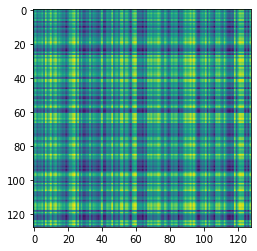

In [120]:
plt.imshow(rel_pos[0][:, :, -1])

In [104]:
indices = repeat(torch.arange(n, device = device), 'j -> b i j', b = b, i = n)

In [107]:
exclude_self_mask = rearrange(~torch.eye(n, dtype = torch.bool, device = device), 'i j -> 1 i j')
indices = indices.masked_select(exclude_self_mask).reshape(b, n, n - 1)
rel_pos = rel_pos.masked_select(exclude_self_mask[..., None]).reshape(b, n, n - 1, 3)

In [109]:
rel_pos.shape

torch.Size([10, 128, 127, 3])

In [110]:
indices.shape

torch.Size([10, 128, 127])